# Introduction: Backward Sensitivities (Adjoint/VJP) in AIFS with Anemoi Inference

This notebook demonstrates how to use the Anemoi inference framework to analyze the sensitivity of the Artificial Intelligence Forecasting System (AIFS) to changes in its input values, focusing on backward sensitivities—also known as adjoint or vector-Jacobian product (VJP) analysis.

**What are backward sensitivities?**
Backward sensitivities answer questions like:
*"What would a 1K perturbation in the t2m (2-meter temperature) forecast for day-10 around Reading trace back to in the current atmospheric conditions, up to first order?"*

This analysis computes how a small change in a future forecast (e.g., temperature at a specific location and time) can be traced back to the present atmospheric state. This is crucial for understanding which current features most influence future predictions and for model validation and improvement.

**How does the perturbation work?**
The perturbation created in this notebook applies a change to all data points within a specified radius around a chosen location. This allows us to study the spatial impact of localized changes and how they propagate backward through the model.

**What will you learn?**
By visualizing these sensitivities, we gain insight into the regions and variables in the current state that most affect the forecast at the target location and time. We will use the `anemoi.inference.runners.sensitivities.SensitivitiesRunner` to compute sensitivities and explore how different input perturbations influence the forecast results.

AIFS leverages machine learning and numerical weather prediction data to provide advanced forecasts. Sensitivity analysis helps us understand how variations in input parameters affect the model's outputs, which is crucial for model validation and improvement.

## Step-by-Step Sensitivity Analysis Workflow

1. **Import Libraries and Modules**
   
Load required Python libraries and Anemoi modules for sensitivity analysis and plotting.



In [1]:
import logging
import torch
import warnings
from typing import Any
from ecmwf.opendata import Client as OpendataClient

from anemoi.inference.outputs.printer import print_state
from perturbantion import Perturbation
from sensitivities import SensitivitiesRunner

from helpers import load_input_state
from helpers import haversine
from helpers import compute_sensitivities_statistics
from plotting import plot_sensitivities
from plotting import plot_summary_sfc
from plotting import plot_summary_pl
from plotting import plot_cross_section

warnings.filterwarnings('ignore')
LOGGER = logging.getLogger(__name__)

assert torch.cuda.is_available(), "CUDA is not available. Please check your GPU setup."

2. **Set Up Experiment Date and Model Checkpoint**

Select the forecast date and specify the model checkpoint to use for inference. We recommend an "o96" model (~1 deg) to make sure the model fits into 1 GPU.


In [ ]:
DATE = OpendataClient().latest()
# import datetime
# DATE = datetime.datetime(2025, 8, 29, 6, 0)

ckpt = "/PATH/TO/CHECKPOINTS/inference-aifs-o96.ckpt"

3. **Load Initial Atmospheric State**

Retrieve the input state for the selected date using helper functions.
- Print the loaded state for inspection.

In [3]:
# Load initial conditions
input_state = load_input_state(DATE, resolution="O96")
print_state(input_state)


😀 date=2025-10-26T12:00:00 fields=90

    10u    shape=(2, 40320) min=-20.0495       max=21.6805       
    t_150  shape=(2, 40320) min=190.324        max=234.127       
    v_400  shape=(2, 40320) min=-51.7483       max=52.6403       
    q_850  shape=(2, 40320) min=2.73287e-08    max=0.0161959     
    z_100  shape=(2, 40320) min=144733         max=163881        
    z_50   shape=(2, 40320) min=184485         max=203647        



4. **Initialize Sensitivity Runner**

Create a `SensitivitiesRunner` instance with the chosen checkpoint and device (GPU).

In [4]:
# Create runner
runner = SensitivitiesRunner(ckpt, device="cuda", perturb_normalised_space=True)

5. **Define Perturbation**

The class `LocalPerturbation` is used here to create a local perturbation, but this class can be extended to implement other types of perturbations as needed for different experiments.
- Specify the variable to perturb (e.g., 2-meter temperature), location (latitude, longitude), and radius (km) for the perturbation.
- The perturbation will affect all data points within the defined radius.
- This perturbation adds 1 in the normalised spaced of the target.

In [5]:
class LocalPerturbation(Perturbation):
    """Perturbation class."""

    def __init__(
        self,
        checkpoint: str,
        perturbed_variable: str,
        perturbation_location: float,
        perturbation_radius_km: float = 100.0,
        patch_metadata: dict[str, Any] = {},
    ) -> None:
        super().__init__(checkpoint, patch_metadata=patch_metadata)

        assert len(perturbation_location) == 2, "perturbation_location must be a tuple of (lat, lon)"
        assert perturbation_location[0] >= -90 and perturbation_location[0] <= 90, "Latitude must be between -90 and 90"
        assert perturbation_location[1] >= 0 and perturbation_location[1] <= 360, "Longitude must be between 0 and 360"

        self.perturbed_variable = perturbed_variable
        self.perturbation_location = torch.tensor(perturbation_location)
        self.perturbation_radius_km = perturbation_radius_km

    def create(self, *args, **kwargs) -> torch.Tensor:
        """Get the perturbation data."""
        var_idx = self.variable_to_output_tensor_index[self.perturbed_variable]
        perturbation = torch.zeros(self.output_shape)

        # Get index of the closest point
        dists = haversine(self.coords, self.perturbation_location)
        closest_idx = torch.where(dists < self.perturbation_radius_km)[0]

        assert len(closest_idx) > 0, "No grid points found within the specified perturbation radius."

        perturbation[..., closest_idx, var_idx] = 1.0
        return perturbation

In [6]:
perturbation = LocalPerturbation(
    ckpt,
    perturbed_variable="2t",
    perturbation_location=(40, 120), # (lat, lon)
    perturbation_radius_km=350.0
)


6. **Run Sensitivity Analysis**

Execute the runner to compute backward sensitivities for the given input state and perturbation.
- Only a 6-hour lead time is supported in this example.
- Print the computed sensitivities for review.

In [7]:
# Compute sensitivities
for sensitivities in runner.run(input_state=input_state, perturbation=perturbation, lead_time="6h"): # only 6h supported
    print_state(sensitivities)
    stats_df = compute_sensitivities_statistics(sensitivities)

Coupled forcings are not supported by this runner: ['lsm', 'sdor', 'slor', 'z']



😀 date=2025-10-26T18:00:00 latitudes=(40320,) longitudes=(40320,) fields=99

    10u            shape=(2, 40320) min=-0.00197705    max=0.00311043    
    sdor           shape=(2, 40320) min=-4.81741e-05   max=6.36947e-05   
    u_150          shape=(2, 40320) min=-0.000945475   max=0.000594639   
    w_100          shape=(2, 40320) min=-0.0951476     max=0.0796445     
    z_700          shape=(2, 40320) min=-0.000439819   max=0.000476554   
    z_925          shape=(2, 40320) min=-0.000550946   max=0.00036845    



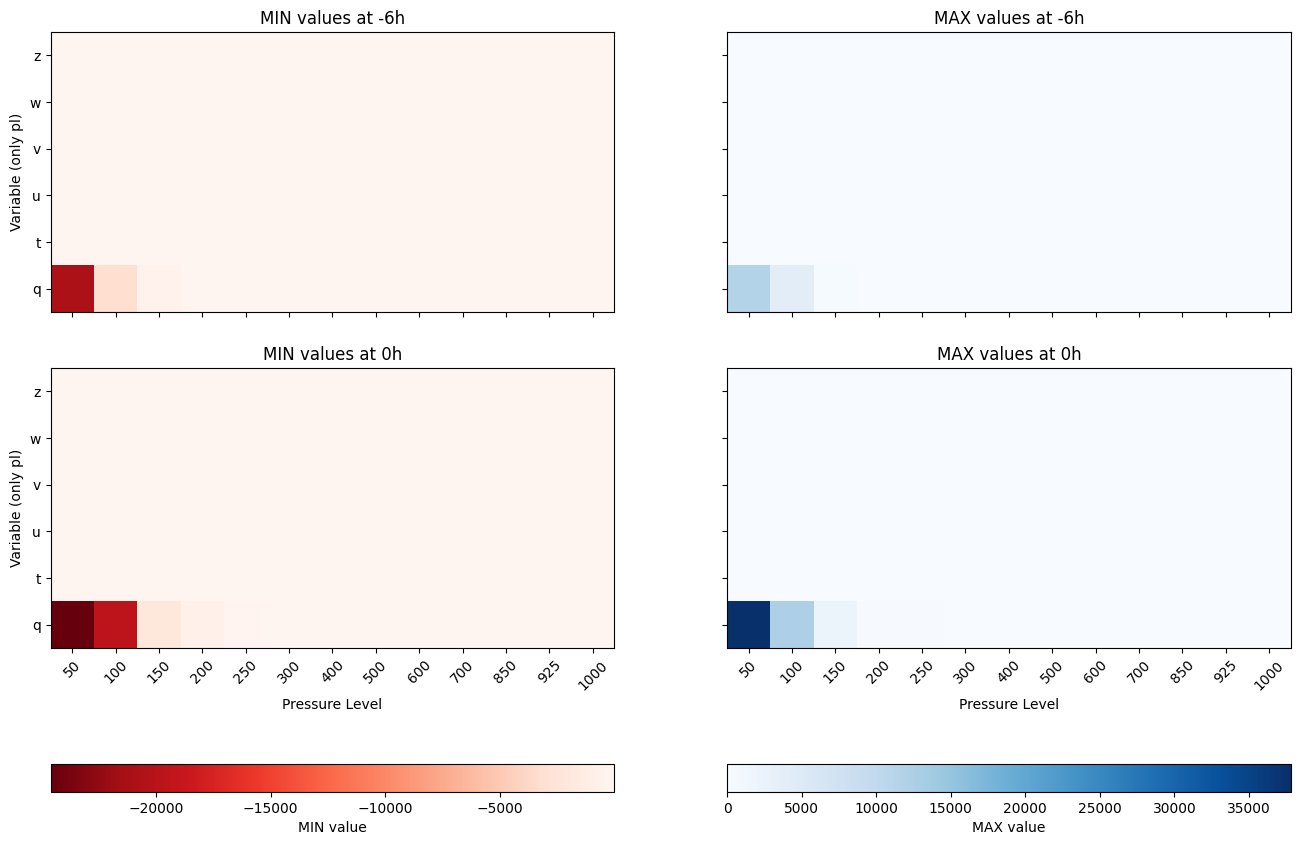

In [8]:
plot_summary_pl(stats_df, stats=["min", "max"], cmaps=dict(min="Reds_r", max="Blues"))

7. **Visualize Sensitivities**

Plot the sensitivities for the perturbed variable (e.g., "2t") to see which regions in the current state most influence the forecast.
   - Optionally, plot sensitivities for other variables (e.g., "z_500") and restrict the visualization to specific areas.

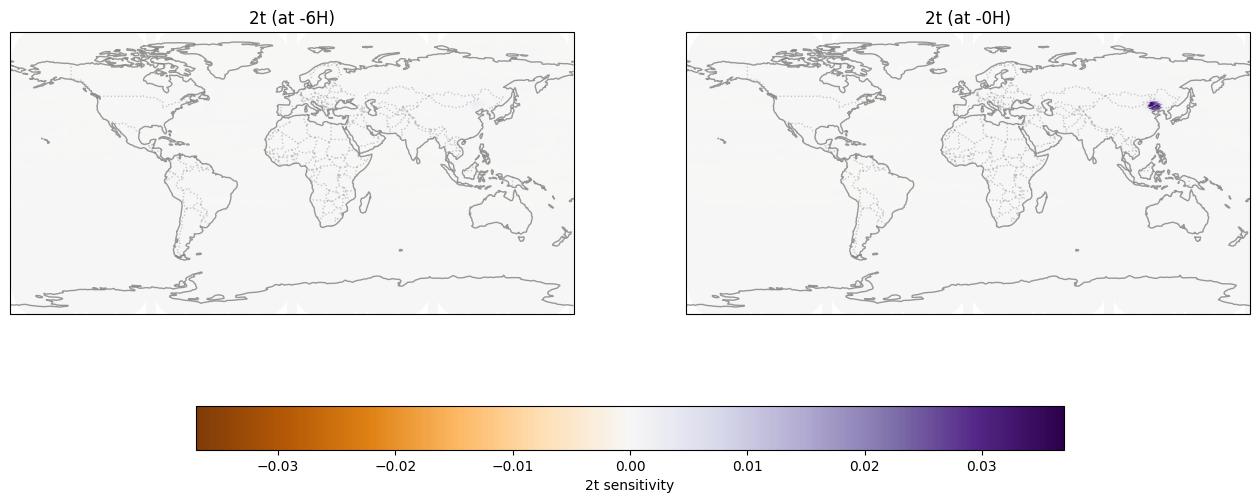

In [9]:
plot_sensitivities(sensitivities, "2t")

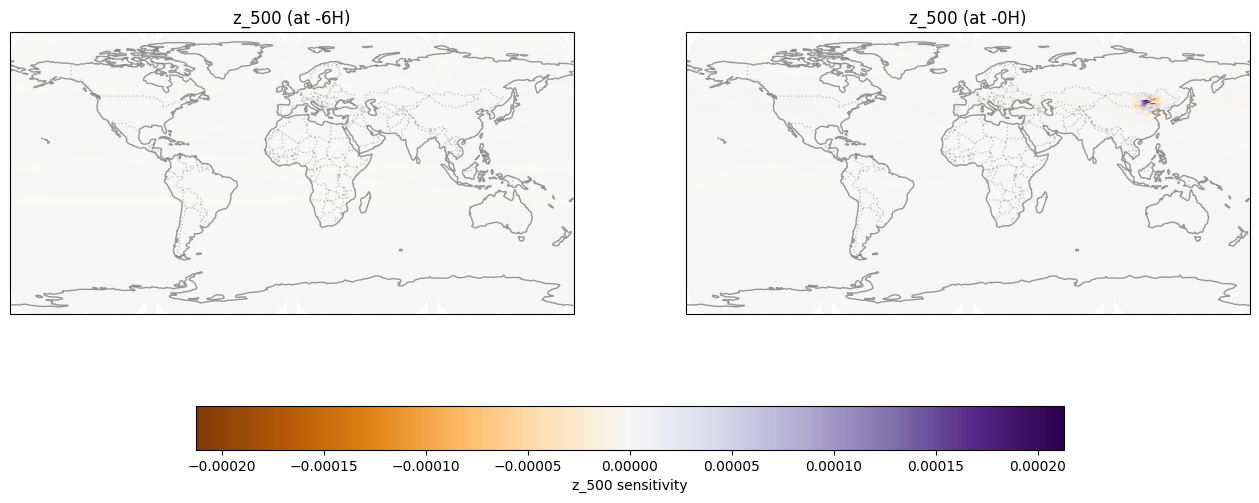

In [10]:
plot_sensitivities(sensitivities, "z_500")

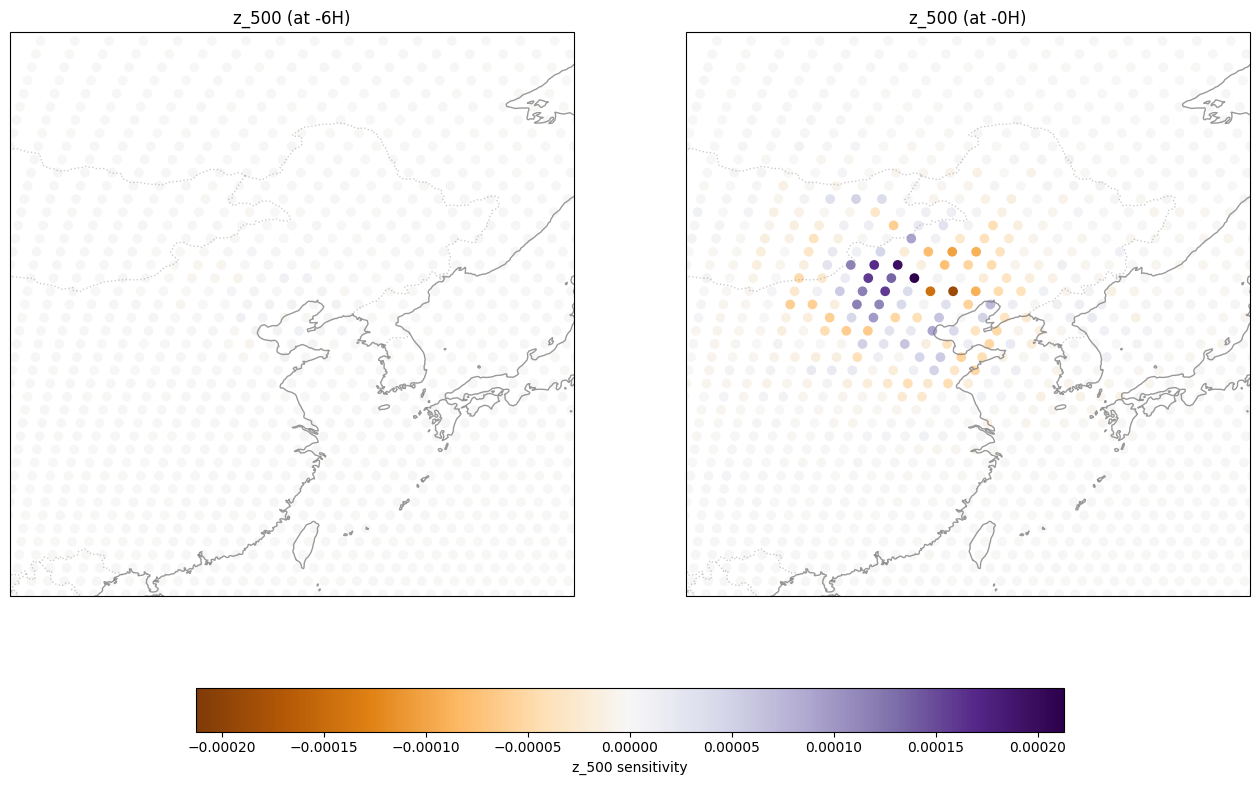

In [11]:
plot_sensitivities(sensitivities, "z_500", area=(100, 140, 20, 60))
# area=(left, right, bottom, top) = (lon_min, lon_max, lat_min, lat_max)

Plotting cross-section sensitivities at longitude=40.5° with 228 points at 13 pressure levels.


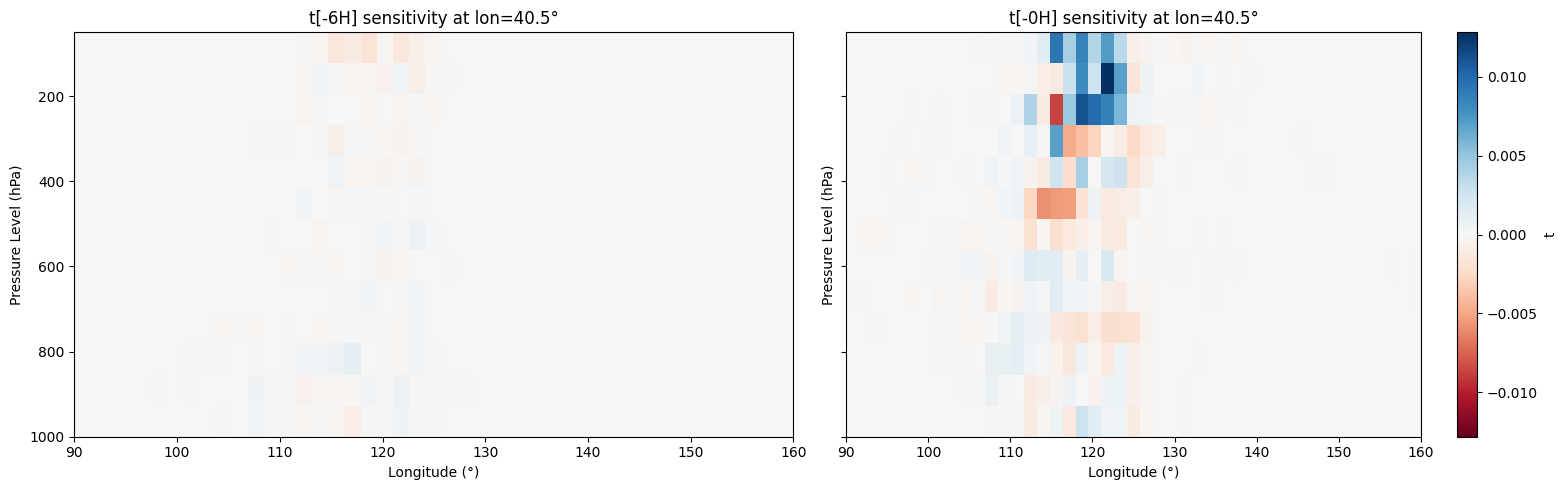

In [12]:
plot_cross_section("t", sensitivities, latitude=40.5, xlim=(90, 160))

### Task 5.1: Plot the sensitivities for another location

Change the location to your home town and have a look at how the sensitivities differ on different pressure levels of temperature when perturbing 2t.


### Task 5.2: Change the perturbation radius

How does this effect the sensitivies?

### Task 5.3: Implement your own Perturbation

For this task, you are asked to implement your own perturbation class. Instead of using the provided Perturbation base class directly, you should create a new class that inherits from it and overrides the create() method. Your implementation can generate any kind of perturbation you choose. Be creative and explore different spatial or variable patterns. A few examples:

- Specify a variable and perturb all pressure levels.
- Apply a perturbation to a latitude/longitude strip around the globe instead of a single grid point.
- Perturb the entire field rather than one specific location.

The goal is to experiment with how different perturbation structures affect the model behaviour.

In [ ]:
class MyPerturbation(Perturbation):
    """Perturbation class."""

    def __init__(
        self,
        checkpoint: str,
        *args, 
        **kwargs,
        patch_metadata: dict[str, Any] = {},
    ) -> None:
        super().__init__(checkpoint, patch_metadata=patch_metadata)

        ## TODO: Save attributes

    def create(self, *args, **kwargs) -> torch.Tensor:
        """Get the perturbation data."""
        perturbation = torch.zeros(self.output_shape)

        # TODO: Create your own perturbation
        return perturbation